In [130]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import time
import math
from numpy.linalg import inv
import copy
from skimage.filters import laplace 

In [131]:
def get_complete_mask(img):
    # Src: https://pysource.com/2021/05/18/instance-segmentation-mask-r-cnn-with-python-and-opencv/
    height, width, _ = np.shape(img)
    net = cv2.dnn.readNetFromTensorflow("./frozen_inference_graph.pb",
                                  "./mask_rcnn_inception_v2_coco_2018_01_28.pbtxt")
    
    blob = cv2.dnn.blobFromImage(img, swapRB=True)
    net.setInput(blob)

    boxes, masks = net.forward(["detection_out_final", "detection_masks"])
    detection_count = boxes.shape[2]

    complete_mask = np.zeros(np.shape(img[:,:,0]))

    for i in range(detection_count):
        box = boxes[0, 0, i]
        class_id = int(box[1])

        if (class_id != 0):
            continue

        # confidence value
        score = box[2]
        if score < 0.4:
            continue

        # Get box Coordinates
        x1 = int(box[3] * width)
        y1 = int(box[4] * height)
        x2 = int(box[5] * width)
        y2 = int(box[6] * height)
        box_height, box_width = (y2-y1, x2-x1)

        # Get the mask
        mask = masks[i, class_id]
        mask = cv2.resize(mask, (box_width, box_height))
        _, mask = cv2.threshold(mask, 0.05, 255, cv2.THRESH_BINARY)

        complete_mask[y1:y2,x1:x2] = mask

    complete_mask /= 255
    return complete_mask

In [133]:
# im_name = "./sam-2.png"
# im = cv2.imread(im_name)

# plt.imshow(im)
# plt.show()

(4032, 3024, 3)
(4032, 3024)
1.0


Text(0.5, 1.0, 'Image Mask')

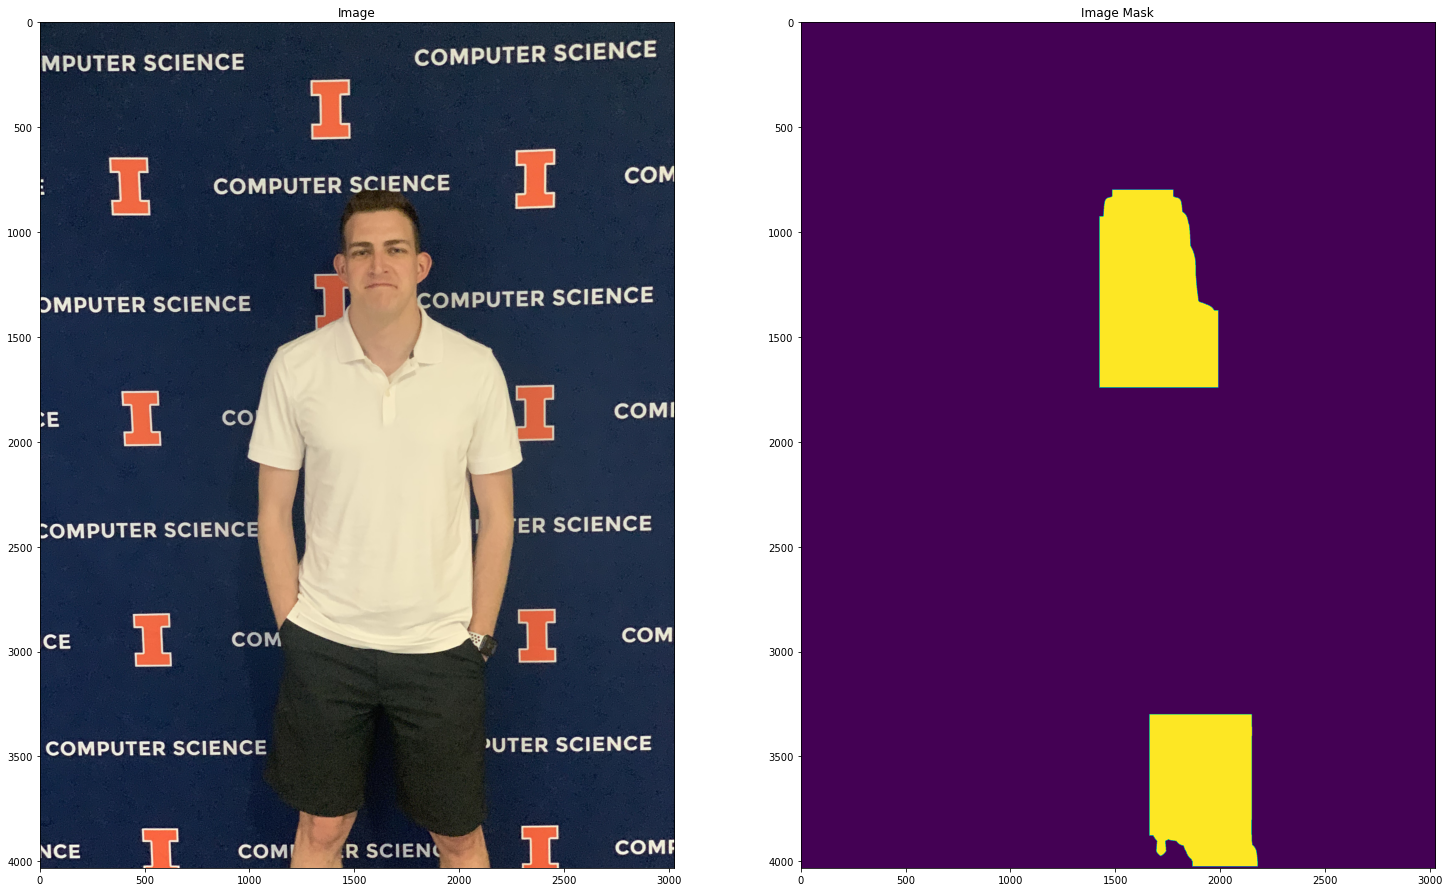

In [139]:
im_name = "./sam-3.png"
mask_name = "./waterfall_mask.png"

im = cv2.imread(im_name) # np.float32(cv2.imread(im_name) / 255.0)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# main_mask = np.float32(cv2.imread(mask_name) / 255.0)
main_mask = np.float32(get_complete_mask(im))
im = np.float32(im / 255.0)

print(im.shape)
print(main_mask.shape)
print(np.amax(main_mask))

fig, axes = plt.subplots(1, 2, figsize=(25,25))
axes[0].imshow(im)
axes[0].set_title("Image")
axes[1].imshow(main_mask)
axes[1].set_title("Image Mask")

In [140]:
main_confidence_matrix = 1 - np.copy(main_mask)

if len(main_mask.shape) == 3:
    main_mask = main_mask[:,:,0]
    main_confidence_matrix = main_confidence_matrix[:,:,0]

source = np.zeros(im.shape)
source[:,:,0] = im[:,:,0] * main_confidence_matrix
source[:,:,1] = im[:,:,1] * main_confidence_matrix
source[:,:,2] = im[:,:,2] * main_confidence_matrix

target = np.zeros(im.shape)
target[:,:,0] = im[:,:,0] * main_mask
target[:,:,1] = im[:,:,1] * main_mask
target[:,:,2] = im[:,:,2] * main_mask
target[target > 0.0] = 1.0

main_im = source + target

# im_H, im_W, im_C = im.shape

# main_mask = copy.deepcopy(im)

# for y in range(im_H):
#     for x in range(im_W):
#         if np.sum(mask[y, x,:]) < 3.0:
#             main_mask[y, x,:] = [0.0, 0.0, 0.0]
   
# main_mask = main_mask[:,:,0]
# main_confidence_matrix = main_confidence_matrix[:,:,0]

Text(0.5, 1.0, 'Image Confidence Mask')

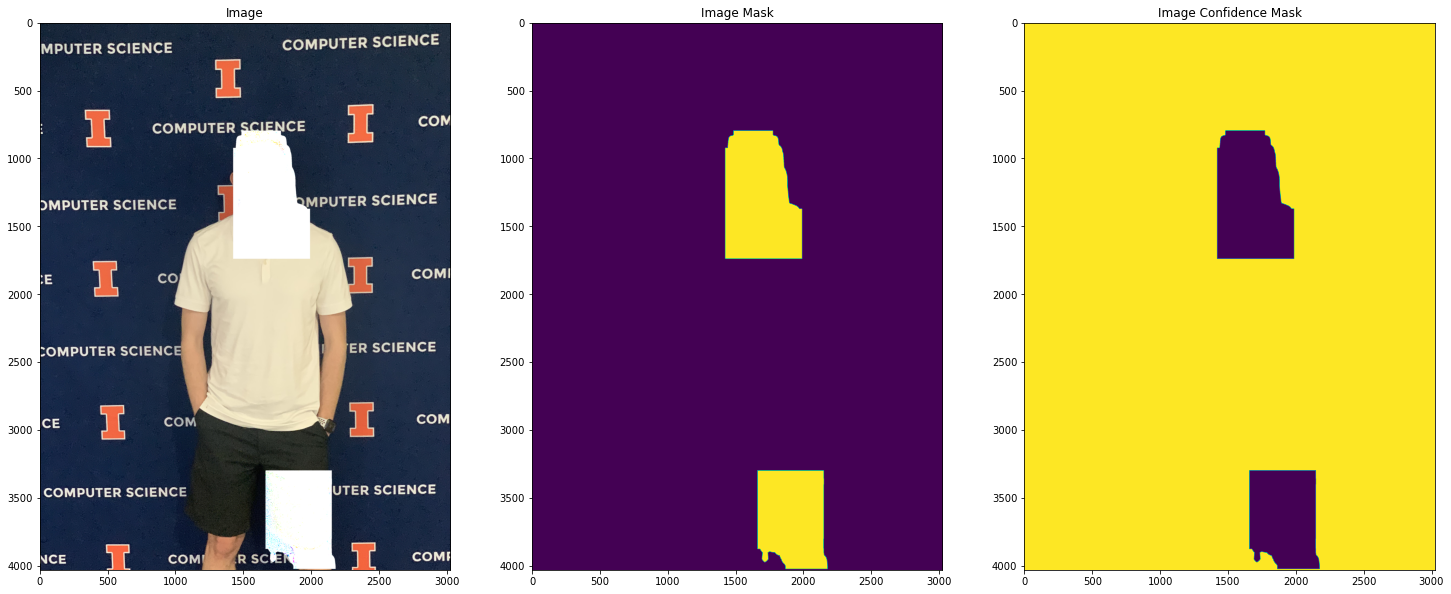

In [141]:
fig, axes = plt.subplots(1, 3, figsize=(25,25))
axes[0].imshow(main_im)
axes[0].set_title("Image")
axes[1].imshow(main_mask)
axes[1].set_title("Image Mask")
axes[2].imshow(main_confidence_matrix)
axes[2].set_title("Image Confidence Mask")

In [142]:
def get_mask_border_indices(mask):
    m_H, m_W = mask.shape
    # (axis, shift)
    shifts = [(0,1), (0,-1), (1,1), (1,-1)]
    outline_mask = np.zeros(np.shape(mask))
    border_indices = [] 

    for shift in shifts:
        shifted_mask = np.roll(mask, shift[1], axis=shift[0])
        temp_border = mask - shifted_mask
        neg_indices = np.where(temp_border < 0)
        temp_border[neg_indices] = 0
        outline_mask = np.logical_or(temp_border, outline_mask)
        
    mask_border_indices = np.transpose(np.nonzero(outline_mask))
    
    i = 0
    while True:
        if (i == len(mask_border_indices)):
            break
        y = mask_border_indices[i, 0]
        x = mask_border_indices[i, 1]
        if y < int(PATCH_SIZE/2) or x < int(PATCH_SIZE/2)\
            or y >= m_H-int(PATCH_SIZE/2) or x >= m_W-int(PATCH_SIZE/2):
            mask_border_indices = np.delete(mask_border_indices, i, axis=0)
            
            # do this because when we delete a row,
            # "i" will now point to the next row instead of the one we just deleted
            # and on the next iteration, we will go to the next next row
            # instead of the next row
            i -= 1
        i += 1
    
    
    return [tuple(x) for x in mask_border_indices], outline_mask

In [143]:
# print(outline_mask[600:625,0:25])
def get_indices_of_k_smallest(arr, k):
    idx = np.argpartition(arr.ravel(), k)
    return tuple(np.array(np.unravel_index(idx, arr.shape))[:, range(min(k, 0), max(k, 0))])

In [144]:
# I is the image, T is the patch, M is the mask
def ssd_patch(I, T, M):
    return ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)

In [145]:
TOL = 5
CHANNEL_NUM = 3

def get_patch_match(sample, current_patch, mask, conf_matrix, matrix_mask):
    height, width, channels = sample.shape
    mask = 1 - mask
    
    ssd = -1
    for i in range(CHANNEL_NUM):
        ssd += ssd_patch(sample[:,:,i].astype(float), current_patch[:,:,i].astype(float), mask.astype(float))
    
    
    # ssd = ssd*conf_matrix+matrix_mask
    fig = plt.figure()
    plt.imshow(ssd, cmap="gray")
    plt.show()
    
    y_coords, x_coords  = get_indices_of_k_smallest(ssd[int(PATCH_SIZE/2):height-int(PATCH_SIZE/2),int(PATCH_SIZE/2):width-int(PATCH_SIZE/2)], TOL)
    index = random.randint(0, min(TOL-1, len(y_coords)-1))
    y_mid_point = y_coords[index]+int(PATCH_SIZE/2)
    x_mid_point = x_coords[index]+int(PATCH_SIZE/2)
    
    half_size = int(PATCH_SIZE/2)
    
    height_start = y_mid_point - half_size
    height_end = y_mid_point + half_size + 1
    
    width_start = x_mid_point - half_size
    width_end = x_mid_point + half_size + 1
    
    conf_value = np.sum(conf_matrix[height_start:height_end,width_start:width_end]) / (PATCH_SIZE**2)
    
    match = np.copy(sample[height_start:height_end,width_start:width_end,:])
    return match, conf_value

In [146]:
def get_normal(prev_coord, next_coord): 
    
    # normal direction vector np
    # 1) the positions of the “control” points of the front are filtered via a bi-dimensional Gaussian kernel -- girl idk how to do this 
    # ii) np is estimated as the unit vector orthogonal to the line through the preceding and the successive points in the list.
    
    # print("previous", prev_coord)
    # print("next", next_coord)

    dx = next_coord[0] - prev_coord[0]
    dy = next_coord[1] - prev_coord[1]

    # print("dx", dx)
    # print("dy", dy)

    normal = [-dy, dx] # (-dy, dx) i think?
    # print("normal", normal)

    norm = np.linalg.norm(normal)
    normal = normal / norm

    # if (normal[0] != -1 and normal[1] != 0):
    #   print("normalized", normal)

    return normal


In [147]:
def get_gradient(patch, patch_loc, Ix, Iy, c_i):
    y = patch_loc[0]
    x = patch_loc[1]
    gradx = Ix[y:y+PATCH_SIZE, x:x+PATCH_SIZE] # change to extract from Ix appropriately
    grady = Iy[y:y+PATCH_SIZE, x:x+PATCH_SIZE] # change to extract from Iy appropriately
    grad_mag = (gradx**2 + grady**2)**0.5 

    ind = [0,0]
    if(len(grad_mag) == 0):
        print("something's wrong")
        print(grad_mag)

    # if y_i == 1070:
    #   print(grad_mag)

    ind = np.unravel_index(np.argmax(grad_mag), grad_mag.shape) # get the max gradient 
    # print(gradx.shape)
    # print(ind)

    grad = np.abs( np.array([gradx[ind[0],ind[1]], grady[ind[0],ind[1]], 0])) # normalize some other way?? maybe dont abs here?
    # print(grad)

    return grad


In [148]:
def get_patch_data_value(patch, patch_loc, c_i, confidence_matrix, Ix, Iy, contours): 
    alpha = 1.0

    prev_coord = [0,0]
    next_coord = [0,0]

    if (c_i > len(contours)):
        print("something is wrong")

    if (c_i > len(contours)):
        prev_coord = [contours[c_i][0], contours[c_i-1][1]]
        next_coord = [contours[c_i][0], contours[c_i][1]]

    if c_i - 1 < 0: # change
        prev_coord = [contours[c_i][0], contours[c_i][1]]
        next_coord = [contours[c_i][0], contours[c_i+1][1]]

    if (c_i - 1 > 0) and (c_i + 1 < len(contours)):
        prev_coord = [contours[c_i][0], contours[c_i-1][1]]
        next_coord = [contours[c_i][0], contours[c_i+1][1]]

    normal = get_normal(prev_coord, next_coord)
    gradient = get_gradient(patch, patch_loc, Ix, Iy, c_i)
    normal_gradient = normal*gradient[:2]
    return np.nan_to_num(np.sqrt(normal_gradient[0]**2 + normal_gradient[1]**2) / alpha + 0.001)


In [149]:
def get_patch_confidence_value(patch_loc, confidences):
    start_y, start_x = patch_loc
    patch_conf = confidences[start_y:start_y+PATCH_SIZE, start_x:start_x+PATCH_SIZE]
    return  np.sum(patch_conf) / (PATCH_SIZE**2)

In [150]:
def get_priority(patch, patch_loc, contour_idx, confidence_matrix, Ix, Iy, contour_list):
    #remember patch_loc = (y,x)
    confidence = get_patch_confidence_value(patch_loc, confidence_matrix)
    data = get_patch_data_value(patch, patch_loc, contour_idx, confidence_matrix, Ix, Iy, contour_list)
    return confidence * data

def get_patch_with_highest_priority(image, contour_list, confidences, Ix, Iy):
    pvalues = []

    for c_i, contour in enumerate(contour_list):
        y = contour[0]
        x = contour[1]

        start_x = max(0, x-int(PATCH_SIZE/2))
        start_y = max(0, y-int(PATCH_SIZE/2))

        patch = image[start_y:start_y+PATCH_SIZE, start_x:start_x+PATCH_SIZE]
        pvalues.append(get_priority(patch, (start_y, start_x), c_i, confidences, Ix, Iy, contour_list))

    max_ind = np.argmax(pvalues)
    p_y = contour_list[max_ind][0]
    p_x = contour_list[max_ind][1]

    start_x = max(0, p_x-int(PATCH_SIZE/2))
    start_y = max(0, p_y-int(PATCH_SIZE/2))

    end_x = start_x + PATCH_SIZE
    end_y = start_y + PATCH_SIZE
    
    return np.copy(image[start_y:end_y, start_x:end_x,:]), (start_y, start_x)

In [151]:
def get_patch_match(image, image_mask, current_patch, current_patch_mask, confidence_matrix):
    height, width, channels = image.shape
    
    ssd_patch_mask = 1 - np.copy(current_patch_mask)
    
    ssd = np.zeros((height, width))
    for i in range(CHANNEL_NUM):
        ssd += ssd_patch(image[:,:,i].astype(float), current_patch[:,:,i].astype(float), ssd_patch_mask.astype(float))
    
    ssd = (ssd * main_confidence_matrix)
    ssd[np.nonzero(main_mask)] = np.amax(ssd)
    
    y_coords, x_coords  = get_indices_of_k_smallest(ssd[int(PATCH_SIZE/2):height-int(PATCH_SIZE/2),int(PATCH_SIZE/2):width-int(PATCH_SIZE/2)], TOL)
    index = 0 # random.randint(0, min(TOL-1, len(y_coords)-1))
    y_mid_point = y_coords[index]+int(PATCH_SIZE/2)
    x_mid_point = x_coords[index]+int(PATCH_SIZE/2)
    
    half_size = int(PATCH_SIZE/2)
    
    height_start = y_mid_point - half_size
    height_end = y_mid_point + half_size + 1
    
    width_start = x_mid_point - half_size
    width_end = x_mid_point + half_size + 1
    
    conf_value = np.sum(confidence_matrix[height_start:height_end,width_start:width_end]) / (PATCH_SIZE**2)
    
    match = np.copy(image[height_start:height_end,width_start:width_end,:])
    
    match_mask = np.copy(image_mask[height_start:height_end,width_start:width_end])
    
    return match, match_mask, conf_value



In [154]:
PATCH_SIZE = 101
CHANNEL_NUM = 3
TOL = 5
MAX_PIXEL_I = 10 # change whatever  

def apply_mask_to_image(image, mask):
    im_copy = np.copy(image)
    im_copy[:,:,0] = image[:,:,0]*mask
    im_copy[:,:,1] = image[:,:,1]*mask
    im_copy[:,:,2] = image[:,:,2]*mask
    
    return im_copy

def fill_hole(image, mask):
    # initialize isophotes (gradients?), confidence, and data terms
    im_H, im_W, im_C = image.shape
    
    confidence_matrix = 1 - mask
    confidence_matrix = confidence_matrix
    
    output_image = np.copy(image)
    
    data = np.zeros((im_H, im_W))
    Ix, Iy, Iz = np.nan_to_num(np.array(np.gradient(image)))
    Ix = np.sum(np.absolute(Ix), axis=2)
    Iy = np.sum(np.absolute(Iy), axis=2)
    
    contour_list, contour_mask = get_mask_border_indices(mask=mask)
    
    while 1:
        current_patch, (y_start, x_start) = get_patch_with_highest_priority(output_image, contour_list, confidence_matrix, Ix, Iy)
        current_patch_mask = np.copy(mask[y_start:y_start+PATCH_SIZE,x_start:x_start+PATCH_SIZE])
        conf_mask = confidence_matrix[y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE]

        match, match_mask, conf_value = get_patch_match(output_image, mask, current_patch, current_patch_mask, confidence_matrix)

        pixels_from_patch = apply_mask_to_image(current_patch, (1-current_patch_mask)) # np.multiply(current_patch,(1-current_patch_mask))
        pixels_from_match = apply_mask_to_image(match, current_patch_mask) # match*current_patch_mask
        finished_patch = pixels_from_patch + pixels_from_match
        
        output_image[y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE] = finished_patch
        
        conf_mask[conf_mask == 0.0] = conf_value
        
        # update the mask
        mask[y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE] = \
            np.logical_and(mask[y_start:y_start+PATCH_SIZE, x_start:x_start+PATCH_SIZE], \
                         match_mask)
        contour_list, _ = get_mask_border_indices(mask)
        if len(contour_list) == 0:
            break
        print(np.sum(mask))
    return output_image



In [ ]:
output_image = fill_hole(np.copy(main_im), np.copy(main_mask))

/var/folders/3k/71m8w99s3977xfvlj8300bmh0000gn/T/ipykernel_31606/632217114.py:20: RuntimeWarning: invalid value encountered in true_divide
  normal = normal / norm


792870.0
792793.0
792746.0
792654.0
790820.0
790687.0
790636.0
787722.0
787621.0
787518.0
787312.0
786900.0
786076.0
783458.0
783374.0
783240.0
780223.0
780172.0
780045.0
776914.0
776806.0
776647.0
773825.0
773723.0
773672.0
773517.0
770910.0
770859.0
770757.0
768156.0
768105.0
765504.0
765403.0
762800.0
762749.0
762663.0
759633.0
757032.0
756981.0
754330.0
752647.0
752588.0
752537.0
749708.0
749586.0
749483.0
749338.0
746068.0
745967.0
745864.0
743162.0
743111.0
740510.0
740409.0
740306.0
737604.0
735003.0
734952.0
732301.0
732150.0
732046.0
731694.0
728885.0
728834.0
726190.0
726089.0
723486.0
723429.0
720433.0
720367.0
720235.0
719957.0
719227.0
719089.0
715763.0
714435.0
714379.0
714305.0
714120.0
710527.0
710471.0
710420.0
707638.0
707535.0
707432.0
704789.0
704669.0
704566.0
701405.0
701303.0
698538.0
698487.0
698335.0
695720.0
695614.0
695402.0
692652.0
692601.0
690000.0
687349.0
687147.0
683321.0
683250.0
679483.0
676863.0
674214.0
671612.0
669657.0
667017.0
664671.0
664531.0
6

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30,30))
axes[0].imshow(im)
axes[0].set_title("Original Image")
axes[1].imshow(output_image)
axes[1].set_title("Clean Image")